# Data Interpolation 
We are given the following table of data, which is inserted into the file ```data.txt```.

| lon | lat | value |
|---|---|---|
| 121.39 | 13.51 | 1.494 |
| 126.19 | 12.02 | 1.934 |
| 130.27 | 13.11 | 2.148 |
| 127.42 | 10.09 | 9.155 |
| 126.14 | 15.33 | 2.221 |
| 125.96 | 14 | 8.1 |
| 123.15 | 10.88 | 2.039 |
| 130.5 | 11.18 | 1.916 |
| 129.08 | 15.78 | 3.729 |
| 122.74 | 15.82 | 7.137 |

The values are for some unspecified quantity but the first two columns represent longitude and latitude data, respectively.

We are asked to construct a spatial grid with 50 rows and 70 columns where longitude is in the range [121.0, 131.0] and latitude is in the range [10.0, 16.0]. 

## Install Packages
We install useful packages for this projects
- numpy for numerical computation and data processing
- scipy for numerical computation and interpolators
- matplotlib for plotting

In [ ]:
pip install numpy
pip install matplotlib
pip install scipy

## Loading Data and Constructing Grid

Next we beign the process of loading the data from the file and constructing the desired grid for interpolation.

In [101]:
import numpy as np
# read the data from the file
data = np.loadtxt('data.txt')
lon, lat, values = data[:,0], data[:,1], data[:,2]
points = data[:,[0,1]]

In [102]:
import numpy as np

# Define the ranges and the number of steps
x = np.linspace(121, 131, 70) # document said 70 columns
y = np.linspace(10, 16, 50)  # and 50 rows

## Selecting a Methond of Interpolation
To select a method of interpolation, we begin by plotting the longitudinal and latitudinal components of the data given.


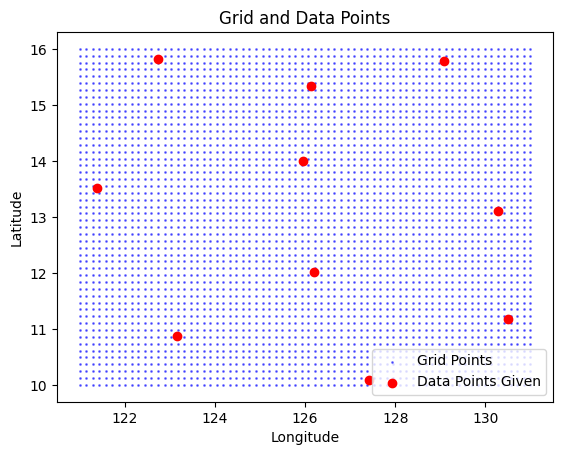

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot the grid points
grid = np.meshgrid(x, y)
ax.scatter(grid[0], grid[1], color='blue', alpha=0.5, s=1, label='Grid Points')

# Plot the lon and lat points
ax.scatter(lon, lat, color='red', label='Data Points Given')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Grid and Data Points')
ax.legend(loc='lower right')
plt.show()




The data is fairly sparse but is disributed throughout the grid. The primary issue is that the convex hull of the data does not encompass the entire desired interpolation grid. Let's attmpt some common interpolation methods; however, we may have to supplement with exprapolation procedures. We begin by consulting the scipy documentation for the interpolation routines.

### [Scipy Interpolation](https://docs.scipy.org/doc/scipy/reference/interpolate.html). 

Considering our options, we decide to limit our options to interpolates that produce smooth curves. (However, we can change our find should be determine this is not needed.) We have the following choices:
- [CloughTocher2DInterpolaotr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator) This produces a smooth curve and minimizes curvatures. Without knowing the what the values represent, it is difficult to know if curvature is important or not.
- [griddata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata) Using the 2D cubic interpolation method, this produces a smooth curve and approximately minimizes curvatures. 

We attempt both methods and compare the results. Some options we use are ```rescaled=True``` because of the difference magnitude comparing the longitudinal and latitudinal data. We also use a fill value of 0 for the time being instead of the default of nan to allow for plotting.

In [139]:
from scipy.interpolate import griddata
from scipy.interpolate import CloughTocher2DInterpolator
grid_x, grid_y = np.mgrid[121:131:70j, 10:16:50j]  # 70 rows and 50 columns on [121,131] x [10,16]
grid_data_output = griddata(points, values, (grid_x, grid_y), method='cubic', rescale=True, fill_value=0)
clough_interp = CloughTocher2DInterpolator(points, values, fill_value=0, rescale=True)
clough_output = clough_interp(grid_x, grid_y) # map the data using the Clough Tocher interpolation

We now compare the results graphical. We could also do a statistical comparison looking at the mean square deviation between the two outputs, but hold off for now.

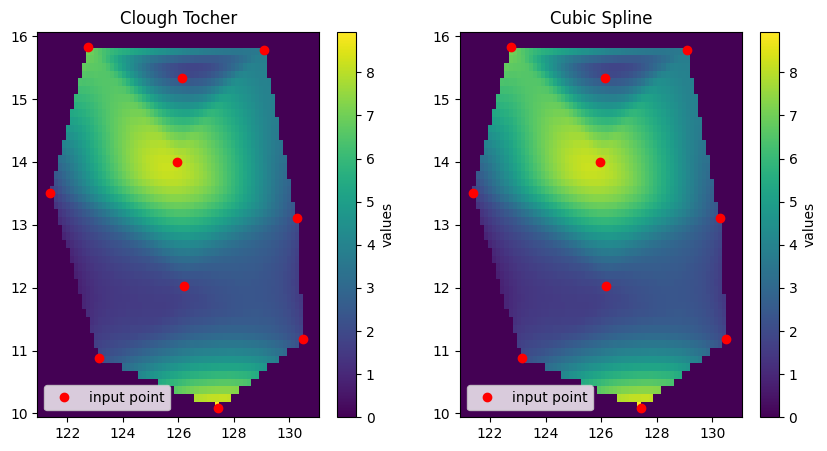

In [146]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot for Clough Interpolation
pcm = axs[0].pcolormesh(grid_x, grid_y, clough_output, shading='auto')
axs[0].plot(lon, lat, "o", label="input point", color='red')
axs[0].legend()
fig.colorbar(pcm, ax=axs[0], label="values")
axs[0].set_title("Clough Tocher")


# Plot for Cubic Spline Interpolation
axs[1].pcolormesh(grid_x, grid_y, grid_data_output, shading='auto')
axs[1].plot(lon, lat, "o", label="input point", color="red")
axs[1].legend()
fig.colorbar(pcm, ax=axs[1], label="values")
axs[1].set_title("Cubic Spline")

plt.show()


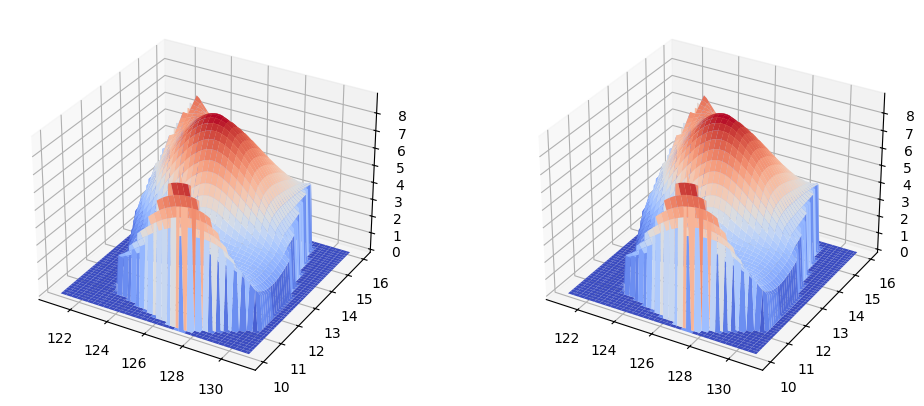

In [160]:
from matplotlib.ticker import LinearLocator
from matplotlib import cm

fig, ax = plt.subplots(1,2, figsize=(12,5), subplot_kw={"projection": "3d"})
ax[0].plot_surface(grid_x, grid_y, clough_output , cmap=cm.coolwarm)
ax[1].plot_surface(grid_x, grid_y, grid_data_output, cmap=cm.coolwarm)


plt.show()

### Results
The above seems to confirm the interpolation is doing an adequate job on the convex hull. However, this does not emcompas the entire grid. We can attempt to fix this by using attempting a mehtod that allows for extrapolation outside the convex hull. We use the following method: [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function_interpolation) and the accompanying ```scipy``` interpolate functions [RBFInterpolator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html#scipy.interpolate.RBFInterpolator).

In [189]:
from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton
rbf_interp = RBFInterpolator(points, values)


The RBF interpretor is not an exclusive 2D interpreter. It can operate in any number of dimensions. As as result, we cannot provide your standand (x,y) input as with the others. The following is massaging the mgrid output and flattening it to array of points. Essentially we go from 70 by 50 grid of points to a list of 3500 points.

In [190]:
gridXY = np.mgrid[121:131:70j, 10:16:50j]
grid_flat = gridXY.reshape(2,-1).T


In [191]:
rbf_output = rbf_interp(grid_flat)  # perform the interpolation/extrapolation across the entire grid


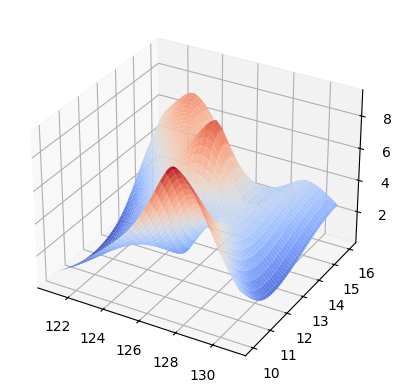

In [194]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
rbf_z = rbf_output.reshape(70,50) # reshape to 70x50 for plotting
ax.plot_surface(grid_x, grid_y, rbf_z, cmap=cm.coolwarm)

Text(0.5, 1.0, 'RBF')

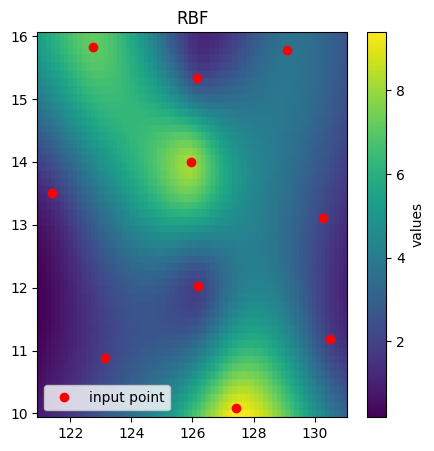

In [197]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot for Clough Interpolation
pcm = axs.pcolormesh(grid_x, grid_y, rbf_z, shading='auto')
axs.plot(lon, lat, "o", label="input point", color='red')
axs.legend()
fig.colorbar(pcm, ax=axs, label="values")
axs.set_title("RBF")